# Demonstration of Messenger Method Code Within mod_mess.py

The messenger method is a method devised by Elsner and Wandelt in 2012 (https://arxiv.org/pdf/1210.4931.pdf) in order to iteratively apply a wiener filter to data sets. The code in the python module mod_mess.py (https://github.com/michaelray1/messenger_method) implements this method as applied to CMB polarization data in order to solve for a B mode only map from input partial-sky CMB data. This allows us to estimate the B mode power spectrum of the CMB which can tell us information about the possible inflationary epoch of the universe.

This filter takes in a set of three maps corresponding to Stoke's parameters I, Q, and U. The output is then a pure B mode, filtered set of these three maps. Through this notebook I will show how to use the code to filter maps. In particular, I will filter a set of simulated CMB-only maps, a set of noise-only maps, and a set of combined maps which are meant to simulate what we would truly observe through a telescope. I'll then describe how an analysis of the effectiveness of this filter is done.

This code relies heavily on the healpy package. Everything about healpy can be found here: https://healpy.readthedocs.io/en/latest/ . Another paper that was very influential for this work can be found here: https://arxiv.org/pdf/1610.03345.pdf . To learn more about this work, check out the poster and logbook posting linked to in the README file of this github (https://github.com/michaelray1/messenger_method).

### Setting up the filter

In [16]:
cd /Users/Michaelray/Documents/Bischoff Research/Messenger Method/Code Demonstration/

/Users/Michaelray/Documents/Bischoff Research/Messenger Method/Code Demonstration


In [17]:
import mod_mess as mm
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import time

To use the filter, we need a noise covariance object, a signal covariance object, and a cooling schedule. The cooling schedule controls a scalable parameter lambda within the filter whose purpose is to speed up convergence of the filter. Below we set up these three objects.

First we set up the noise covariance object with an Nside of 512. The Nside value just controls how large the noise covariance object will be. This Nside must be consistent with the size of the signal covariance matrix, or else the program will throw an error when we get to the filtering portion. Once we set up the object, we will create the noise covariance matrix by taking it to be diagonal with two copies of 1/mask being the diagonal entries. The reason we take two copies of 1/mask is because the noise covariance matrix must match the size of the signal covariance matrix, which has both an E and B mode component. So we are saying that the noise covariance for the B mode portion is 1/mask and also the noise covariance for the E mode portion is 1/mask. The mask here is shown below using a Mollweide projection. You will notice that we set all of the nan values in the mask to be 1e-10. This is simply because setting them to identically zero causes issues when we take the inverse and then try to use the noise covariance matrix to do computations. So, we just set it to a value so small that our filter won't know the difference between this value and zero.

Before we do anything, however, we'll set up the parameters Nside, Npix, Nsph and ellmax. These have to do with the resolution of our map and setting them up at the very start ensures that everything will be consistent throughout the code so that we don't run into trouble somewhere down the line when the sizes of some objects don't match up.

In [18]:
Nside = 512
Npix = 12*Nside**2
Ellmax = 3*Nside-1
Nsph = int(np.sum(1.0 * np.arange(Ellmax+1) + 1.0))

In [19]:
N_cov = mm.Noise_cov(Nside=Nside)

mask = hp.read_map('512.fits')
mask[np.where(np.isnan(mask))] = 1e-10
Ndiag = np.concatenate((mask**(-1), mask**(-1)),axis=0)

N_cov.make_matrix(matrix = Ndiag)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


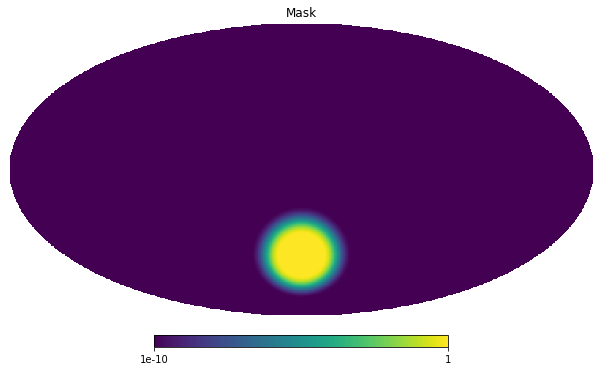

In [21]:
hp.mollview(mask, title='Mask')

Just to make sure everything is working as it should, let's check that our noise covariance matrix is diagonal. This should be the case because we put in an object of size Npix (rather than Npix squared, which would indicate a non-diagonal matrix).

In [22]:
N_cov.is_diagonal

True

We will now set up the signal covariance matrix. This will be done by using the power spectra we expect to see based on theoretical calculations (with no primordial gravitational waves). So our signal covariance consists of a B-mode signal that is expected if inflation did not, in fact, occur in the early universe. The E-mode part of the signal covariance is set to zero (because we want a pure-B filter). Let's first load in the theoretical power spectra and take a look at them.

In [24]:
dls = np.genfromtxt("/Users/Michaelray/Documents/Bischoff Research/Messenger Method/Code Demonstration/ffp10_lensedCls.dat")
dls = np.insert(dls, [0], [1,0,0,0,0], axis = 0)
dls = np.insert(dls, [0], [0,0,0,0,0], axis = 0)
d_ell = np.array([dls[:,0]])
d_spectra = dls[:,1:]
Cls = np.array([d_spectra[i]*2*np.pi/(i * (i+1)) for i in range(len(d_spectra))])
c_ells = np.concatenate((np.transpose(d_ell), Cls), axis = 1)
c_ells_t = np.transpose(c_ells)
B_pspec = c_ells_t[3, :1535]

/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, '$C_{\\ell}$ ($\\mu K^2$)')

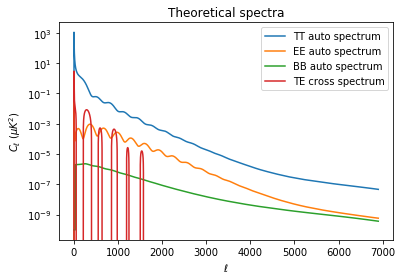

In [85]:
plt.semilogy(c_ells_t[1,:], label='TT auto spectrum')
plt.semilogy(c_ells_t[2,:], label='EE auto spectrum')
plt.semilogy(c_ells_t[3,:], label='BB auto spectrum')
plt.semilogy(c_ells_t[4,:], label='TE cross spectrum')
plt.legend()
plt.title('Theoretical spectra')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$ ($\mu K^2$)')

Now let's use the BB auto spectra to create our signal covariance matrix. The signal covariance object in our case is diagonal, with the diagonal values being the BB spectrum expanded out to be the number of spherical harmonic coefficients present in our data. In our case, we will just take the first 1536 values in the BB spectrum (because this number is consistent with the resolution our data). We will then use the function hp.almxfl to expand the spectrum out to its corresponding spherical harmonic coefficients. The choice of spherical harmonic coefficients here are not unique because going from spherical harmonic coefficients to a power spectrum involves taking an average. Thus going from a power spectrum to spherical harmonic coefficients just means creating a set of coefficients such that the m values, when taking the absolute square of them, average to the power spectrum.

Another thing to note is that we have applied a beam to our theoretical power spectrum. This is because when we actually take data, we have to account for a beam which smooths out our data. The intuitive way to think about this is that we don't have perfect resolution in our measurements, so the data we actually get out is an average over measurements that are close together on the sky. In this case, we have used a beam with size (full width half maximum) of 24.2 arcminutes. This is then used to create a gaussian function which smooths the spectrum as described above.

In [26]:
FWHM = 24.2
sigma_rad = (FWHM/(np.sqrt(8*np.log(2))))*(np.pi/(60*180))
B_ell_squared = np.e**((-1)*(ells**2)*(sigma_rad**2))
B_pspec[:30]=1e-10
B_pspec_beamed = B_pspec*B_ell_squared
B_cov = hp.almxfl(np.ones(Nsph), B_pspec_beamed)
S_B = np.concatenate((np.zeros(Nsph), B_cov), axis = 0)

S_cov = mm.Sig_cov()
S_cov.make_matrix(matrix = S_B)

Just as with the noise covariance matrix, the signal covariance matrix should be diagonal because we put in an object of size Nsph rather than Nsph squared, which would indicate a non-diagonal matrix. Let's check that this is correct.

In [27]:
S_cov.is_diagonal

True

We've now got our signal and noise covariance objects. We still need a cooling schedule for this code to work. The cooling schedule has to do with how the lambda value in the messenger method is decreased. The final value of the cooling schedule must be one, because only when lambda is one do the messenger method equations reduce to a true wiener filter (filter which minimizes chi-squared). Built-in options for the cooling schedule are standard_cooling or linear_lam. 

standard_cooling begins with a lambda value of 1300, then bumps lambda down to 100, then multiplies lambda by some factor eta (set by default to 0.7 but that can be adjusted) on each iteration until lambda falls below 1, at which point we tack on the value 1 to the lambda list five times. So the lambda value in the iteration goes as follows: 1300, 100, 100 * eta, 100 * eta^2, 100 * eta^3, ...., 1, 1, 1, 1, 1. Various cooling schedules were played around with when this code was being written and this one seemed to work the best in the cases we were interested in.

The linear_lam option begins at some specified lambda (adjustable in the function), and then decreases lambda by some set value on each iteration until it falls below 1, at which point we tack on the value 1 to our lambda list. 

The custom cooling schedule just works by taking in a list of lambda values and converting it to a numpy array. If you use the custom cooling schedule remember that it is imperative that the final value is 1. If it is not, then the messenger method does not reduce to a wiener filter.

We will work with the standard_cooling cooling schedule for this demonstration.

In [28]:
Cooling = mm.Cooling()
Cooling.lam_list = Cooling.standard_cooling(eta=0.7)

Now we are ready to create our messenger method wiener filter object.

In [29]:
mmwf = mm.Mmwf(N_cov = N_cov, Sig_cov = S_cov, Cooling = Cooling)

### Filtering noise-only maps

So our filter is now ready to take in data. This filter object can now be thought of as a black box where we input data and we get B-mode only data out. Let's try using this on some data. First let's look at what happens when we put noise through our filter. The map shown below is a noise-only simulation. That is, it is supposed to mimic noise that will be picked up by the detector when the experiment is run. I will then multiply this map by 10^6 so that we can look at it in units of micro Kelvin. You may notice that the noise is very large around the edge of the mask. This is what we expect from our detector because that area will not be observed at as high of an accuracy as in the middle of the unmasked area.

In [57]:
noise_maps = hp.read_map('/Users/Michaelray/Documents/Bischoff Research/Messenger Method/Code Demonstration/cmbs4_04_noise_f095_b24_ellmin30_map_0512_mc_0000.fits', field=(0,1,2))
noise_maps = noise_maps*1e6
noise_maps[np.where(np.isnan(noise_maps))] = 0.0

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [58]:
np.shape(noise_maps)

(3, 3145728)

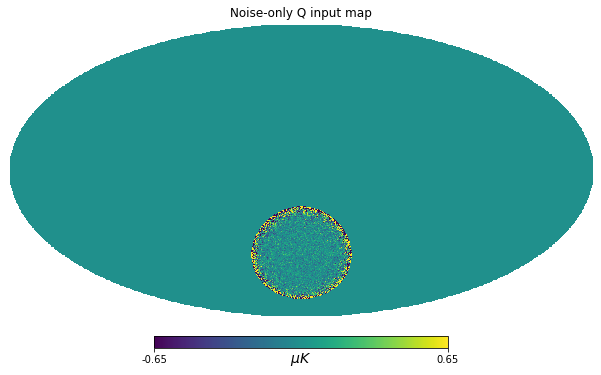

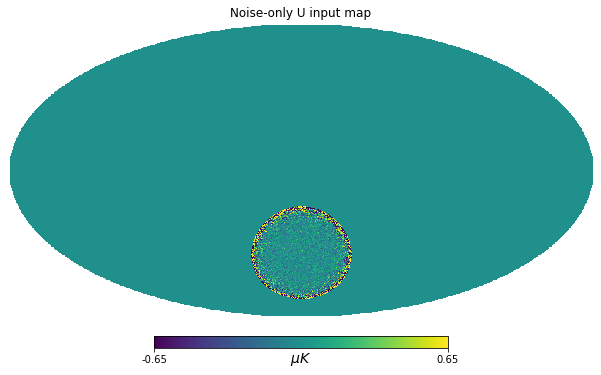

In [64]:
hp.mollview(noise_maps[1,:], title='Noise-only Q input map', unit = '$\mu K$', min=-0.65, max=0.65)
hp.mollview(noise_maps[2,:], title='Noise-only U input map', unit = '$\mu K$', min=-0.65, max=0.65)

We can get a better look at these maps by zooming in on the unmasked region using hp.gnomview.

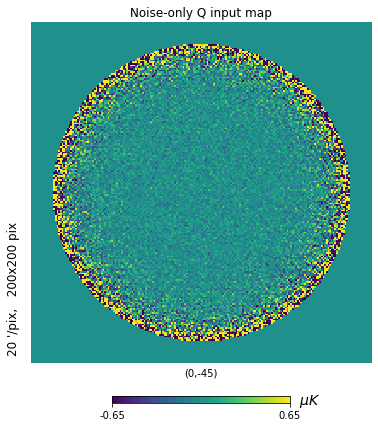

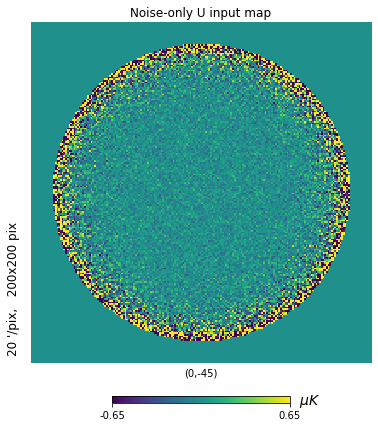

In [73]:
hp.gnomview(noise_maps[1,:], title='Noise-only Q input map', min=-0.65, max=0.65, unit = '$\mu K$', reso=20, rot=(0, -45))
hp.gnomview(noise_maps[2,:], title='Noise-only U input map', min=-0.65, max=0.65, unit = '$\mu K$', reso=20, rot=(0, -45))

We can see visually that this looks like random noise with the caveat that the noise gets larger as we get closer to the edge of the unmasked area. Now let's filter this noise and see what we get out.

In [65]:
start_time = time.clock()
out_noise_alms = mmwf.filter_map_pureB(data = noise_maps)
computation_time = time.clock() - start_time
print("Computation time (seconds) = ", computation_time)

/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
print(np.shape(out_noise_alms))
print(Nsph*2)

(2360832,)
2360832


As can be seen above, the size of our output maps is the same as Nsph * 2. Our output is the spherical harmonic coefficients for E and B modes. At the end of our iterative scheme, however, we explicitly project out the E-mode components. So the first Nsph entries in the filtered_maps object are all zeros. The last Nsph are what we actually care about. These are the B-mode spherical harmonic coefficients. Let's turn these into I, Q, and U maps so we can look at them.

In [72]:
noise_alms = np.array([np.zeros(Nsph), out_noise_alms[:Nsph], out_noise_alms[Nsph:]])
filtered_noise_maps = hp.alm2map(noise_alms, nside=Nside, lmax=Ellmax, pol=True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


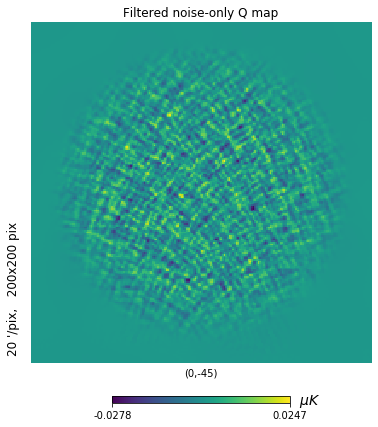

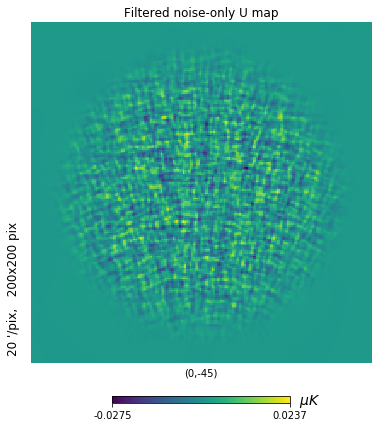

In [75]:
hp.gnomview(filtered_noise_maps[1,:], title='Filtered noise-only Q map', unit = '$\mu K$', reso=20, rot=(0, -45))
hp.gnomview(filtered_noise_maps[2,:], title='Filtered noise-only U map', unit = '$\mu K$', reso=20, rot=(0, -45))

As is evident from the figures, the filter smooths out the maps and we can see that we have B-modes because we get diagonal lines in the Q map and vertical/horizontal lines in the U map. We expected to get B-modes because we are using a pure-B filter. We also see that the signal has been suppressed based on comparing the scale of these figures to the scale of the input maps. When the input to the filter is B-mode only maps, this suppression phenomenon is referred to as signal suppression and plays a major part in the analysis of the maps. See the poster and logbook posting linked to in the README file on this github (https://github.com/michaelray1/messenger_method) to find more about signal suppression. The signal suppression is ultimately measured and utilized by creating what are called band power window functions.

### Filtering CMB-only maps

Now let's see what happens when we send in CMB-only maps. This simulation was created using theoretical power spectra for the CMB, thus it is what we expect to observe in the CMB in the absence of primordial gravitational waves (which result from an inflationary epoch early in the universe).

In [77]:
llcdm_maps = hp.read_map('/Users/Michaelray/Documents/Bischoff Research/Messenger Method/Code Demonstration/cmbs4_04_llcdm_f095_b24_ellmin30_map_0512_mc_0000.fits', field=(0,1,2))
llcdm_maps = llcdm_maps*1e6
llcdm_maps[np.where(np.isnan(llcdm_maps))] = 0.0

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


Now let's take a look at these CMB-only maps.

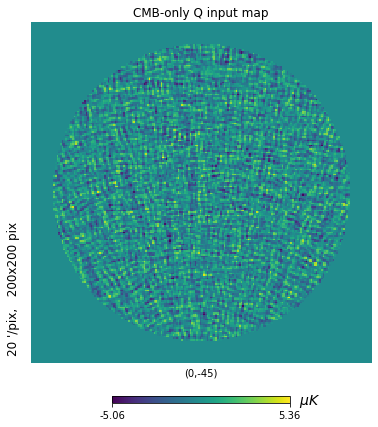

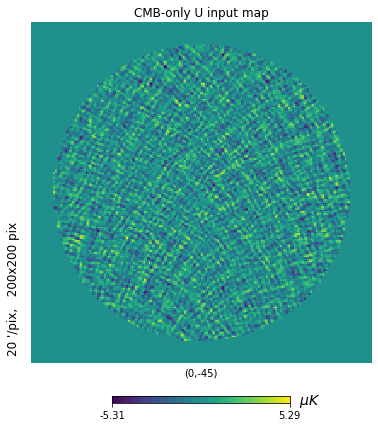

In [79]:
hp.gnomview(llcdm_maps[1,:], title='CMB-only Q input map', unit = '$\mu K$', reso=20, rot=(0, -45))
hp.gnomview(llcdm_maps[2,:], title='CMB-only U input map', unit = '$\mu K$', reso=20, rot=(0, -45))

These (as we expect) look like E-modes. We see this by observing that the Q map has vertical/horizontal lines and the U map has diagonal lines. This is expected because there are many processes which would create E-modes in the CMB sky, but primordial gravitational waves are the only known source of possible B-modes other than gravitational lensing of the light on its way to our observatories. Let's now filter these maps.

In [80]:
start_time = time.clock()
out_llcdm_alms = mmwf.filter_map_pureB(data = llcdm_maps)
computation_time = time.clock() - start_time
print("Computation time (seconds) = ", computation_time)

/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


Now let's turn these filtered alm's into maps so we can look at them.

In [83]:
llcdm_alms = np.array([np.zeros(Nsph), out_llcdm_alms[:Nsph], out_llcdm_alms[Nsph:]])
filtered_llcdm_maps = hp.alm2map(llcdm_alms, nside=Nside, lmax=Ellmax, pol=True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


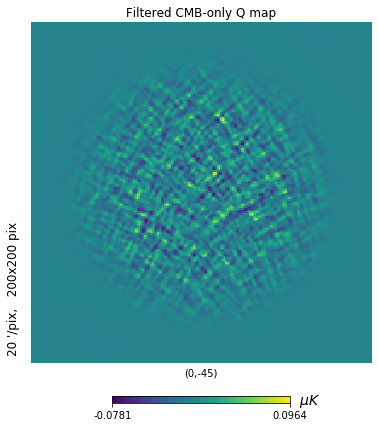

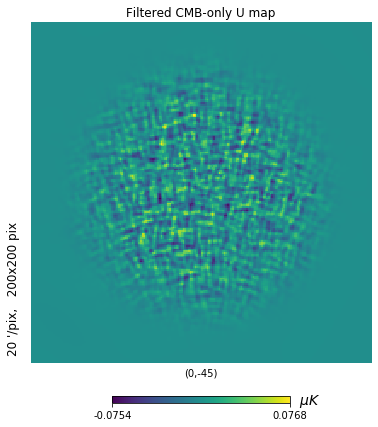

In [84]:
hp.gnomview(filtered_llcdm_maps[1,:], title='Filtered CMB-only Q map', unit = '$\mu K$', reso=20, rot=(0, -45))
hp.gnomview(filtered_llcdm_maps[2,:], title='Filtered CMB-only U map', unit = '$\mu K$', reso=20, rot=(0, -45))

We again see that the output visually looks like B-modes (diagonal lines in the Q map and vertical/horizontal lines in the U map).

### Description of an analysis of the filter

At this point, it has been demonstrated how to use this code to filter maps. When filtering real data to search for primordial gravitational waves, we want to use the best filtering procedure so that we obtain the most accurate data possible. To test the effectiveness of a filter, we must perform a statistical analysis. 

The idea is to simulate a bunch of maps that contain CMB signal and noise. Then run them through the filter and obtain an output binned BB spectrum for each. By looking at the variance of this data set in each bin, we can see how spread out our data is. When we actually take data with our telescope, it is as if we are choosing one of these simulated maps. Thus, using a filter that minimizes the variance on a bunch of simulated maps, is a filter that minimizes the error on our measurement when we take data.

The process of obtaining an output binned BB spectrum from combined CMB signal and noise maps provides some complication. To do this, we first obtain a noise bias measurement by running many (on the order of 10^2 or 10^3) simulated noise maps through our filter and averaging the filtered BB power spectrum of these filtered maps. This gives you the mean expected contribution to the output data due to noise. Similarly, we can run a bunch of E-mode only maps through the filter to obtain the mean contribution of E-modes to the output (this should be small since we are using a pure-B filter). The final contributor to the equation is the signal suppression briefly mentioned above. This is found by running many B-mode only maps through the filter and seeing how much real B-mode signal is suppressed through the use of our filter. To obtain a final output BB power spectrum we then use the equation below.

$$
Signal = \frac{filtered\ combined\ data - noise\ contribution - E\ mode\ contribution}{signal\ suppression}
$$

Doing this 100 or so times gives a good estimate of the variance of the output measurement (this tells us how large our error bar on our measurement is). See the poster and logbook posting mentioned to in the introduction of this jupyter notebook to see the results of our analysis of the filter.